In [1]:
# Code adapté des liens suivants : 
# https://medium.com/geekculture/neural-machine-translation-using-sequence-to-sequence-model-164a5905bcd7
# https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Adaptation à notre cas

# Traitement des labels

df_train = pd.read_csv("train.csv")

words_to_use = set()
char_to_predict = set()
input_texts = []
target_labels = []

max_input_text_length = 0
max_label_length = 0

base_labels = df_train.ICD10.values
base_texts = df_train.RawText.values

for idx_sample in range(len(df_train.ICD10)) : 

    base_text = base_texts[idx_sample]
    base_label = base_labels[idx_sample]
    
    input_text = base_text.split()
    target_label =  ["<s>"] + list(base_label) + ["</s>"]    
    
    if len(input_text) > max_input_text_length : 
        max_input_text_length = len(input_text)
    
    if len(target_label) > max_label_length : 
        max_label_length = len(target_label)
    
    for word in input_text : 
        words_to_use.add(word)
    
    for char in target_label : 
        char_to_predict.add(char) 
        
    input_texts.append(input_text)
    target_labels.append(target_label)
            
words_to_use = sorted(list(words_to_use))
char_to_predict = sorted(list(char_to_predict))

print("Nombre de données d'entrainement :", range(len(df_train.ICD10)))
print("Nombre de mots uniques :", len(words_to_use))
print("Nombre de caractères uniques :", len(char_to_predict))
print("Taille max texte :", max_input_text_length)
print("Taille max label :", max_label_length)

Nombre de données d'entrainement : range(0, 181763)
Nombre de mots uniques : 35601
Nombre de caractères uniques : 38
Taille max texte : 31
Taille max label : 6


In [5]:
words_to_use_with_unk = words_to_use # Liste des mots avec le token inconnu, permet d'entrainer le label encoder
words_to_use_with_unk.append("<UNK>")

dict_word_index = dict((w, i) for i, w in enumerate(words_to_use_with_unk))
dict_char_index = dict((c, i) for i, c in enumerate(char_to_predict))

#  Dictionnaire qui permettront de créer les matrices d'entrée de l'encodeur, et de l'entrée / sortie du décodeur
dict_index_word = dict((i, w) for i, w in enumerate(words_to_use_with_unk))
dict_index_char = dict((i, c) for i, c in enumerate(char_to_predict))

In [6]:
BATCH_SIZE= 512 

def data_batch_generator(input_texts, target_labels, batch_size=BATCH_SIZE):
    while True:
        for i in range(0, len(input_texts), batch_size):
            encoder_input_data = np.zeros((batch_size, max_input_text_length), dtype='float32') # Padding avec des zéros
            decoder_input_data = np.zeros((batch_size, max_label_length), dtype='float32') # Padding avec des zéros
            decoder_target_data = np.zeros((batch_size, max_label_length, 38), dtype='float32' ) # Padding avec des zéros
            for j, (text, lab) in enumerate(zip(input_texts[i:i+batch_size], target_labels[i:i+batch_size])):
                for t, word in enumerate(text):
                    if word in words_to_use : 
                        encoder_input_data[j,t] = dict_word_index[word]
                    else : 
                        encoder_input_data[j,t] = dict_word_index["<UNK>"]
                for t, char in enumerate(lab):
                    if t < len(lab) - 1:
                        decoder_input_data[j,t]= dict_char_index[char]
                    if t>0:
                        decoder_target_data[j,t-1, dict_char_index[char]] = 1.
            yield ([encoder_input_data, decoder_input_data], decoder_target_data) 

In [7]:
# Architecture de l'encodeur
encoder_input = Input(shape=(None, ))
encoder_embd = Embedding(35602,200, mask_zero=True)(encoder_input) # Taille de l'espace d'embedding : 200
encoder_lstm = LSTM(250, return_state=True)
encoder_output, state_h, state_c = encoder_lstm(encoder_embd)

# Etats cachés et de mémoire de la couche de LSTM, utilisés en entrée du décodeur
encoder_states= [state_h, state_c]

In [8]:
# Architecture du premier décodeur
decoder_input = Input(shape=(None,))
decoder_embd = Embedding(38, 200, mask_zero=True)
decoder_embedding= decoder_embd(decoder_input)

decoder_lstm = LSTM(250, return_state=True,return_sequences=True )
decoder_outputs, _, _= decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense= Dense(38, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model_seq2seq = Model([encoder_input, decoder_input], decoder_outputs)

In [9]:
model_seq2seq.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    7120400     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    7600        ['input_2[0][0]']                
                                                                                              

In [10]:
import keras.backend as K 

# Ajout à la main de la métrique de F1-score

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

metrics = [ 'accuracy', f1_score ]

In [11]:
model_seq2seq.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [12]:
df_val = pd.read_csv("val.csv")

In [13]:
# Traitement des labels de validation

input_texts_val = []
target_labels_val = []

base_labels_val = df_val.ICD10.values
base_texts_val = df_val.RawText.values

for idx_sample in range(len(df_val.ICD10)) : 

    base_text_val = base_texts_val[idx_sample]
    base_label_val = base_labels_val[idx_sample]
    
    input_text_val = base_text_val.split()
    target_label_val =  ["<s>"] + list(base_label_val) + ["</s>"]    

    input_texts_val.append(input_text_val)
    target_labels_val.append(target_label_val)

In [15]:
# Calcul du nombre d'itérations par epochs ( en fonction de la batch size )
steps_per_epoch= np.ceil(len(input_texts)/BATCH_SIZE)
steps_per_epoch_val = np.ceil(len(input_texts_val)/BATCH_SIZE)

In [16]:
print(input_texts[:10])

[['Thrombose', 'veineuse', 'profonde', 'cuisse', 'gauche'], ['Hémiplégie', 'post-traumatique'], ['Masculinisation', 'avec', 'hyperplasie', 'surrénale'], ['Hyperammoniémie', 'cérébrale'], ['Fistule', 'artérioveineuse', 'congénitale', 'périphérique', 'vaisseaux', 'pulmonaires'], ['Prothèse', 'valvulaire', 'mécanique'], ['Tumeur', 'maligne', 'parties', 'molles', 'fesse'], ['Complexe', 'XP/CS'], ['Sclérodermie', 'acrosclérotique', 'néonatale'], ['VIH', 'pelvienne', 'femme', 'NCA', 'inflammatoire', 'compliquant', 'la', 'grossesse', 'affectant', 'foetus', 'ou', 'nouveau-né']]


In [17]:
# train model
history_seq2seq = model_seq2seq.fit(data_batch_generator(input_texts, target_labels), 
                steps_per_epoch= steps_per_epoch, 
                validation_data= data_batch_generator(input_texts_val, target_labels_val, BATCH_SIZE),
                validation_steps=steps_per_epoch_val,
                epochs=10,
                verbose=1)

Epoch 1/10
356/356 [==============================] - 1580s 4s/step - loss: 1.3748 - accuracy: 0.4231 - f1_score: 0.3198 - val_loss: 0.9389 - val_accuracy: 0.6004 - val_f1_score: 0.4849
Epoch 2/10
356/356 [==============================] - 1311s 4s/step - loss: 0.7625 - accuracy: 0.6817 - f1_score: 0.5663 - val_loss: 0.7190 - val_accuracy: 0.7019 - val_f1_score: 0.5951
Epoch 3/10
356/356 [==============================] - 1312s 4s/step - loss: 0.5382 - accuracy: 0.7807 - f1_score: 0.6571 - val_loss: 0.6348 - val_accuracy: 0.7447 - val_f1_score: 0.6377
Epoch 4/10
356/356 [==============================] - 4120s 12s/step - loss: 0.4143 - accuracy: 0.8316 - f1_score: 0.7028 - val_loss: 0.5891 - val_accuracy: 0.7690 - val_f1_score: 0.6564
Epoch 5/10
356/356 [==============================] - 1302s 4s/step - loss: 0.3385 - accuracy: 0.8618 - f1_score: 0.7281 - val_loss: 0.5636 - val_accuracy: 0.7839 - val_f1_score: 0.6681
Epoch 6/10
356/356 [==============================] - 23069s 65s/step

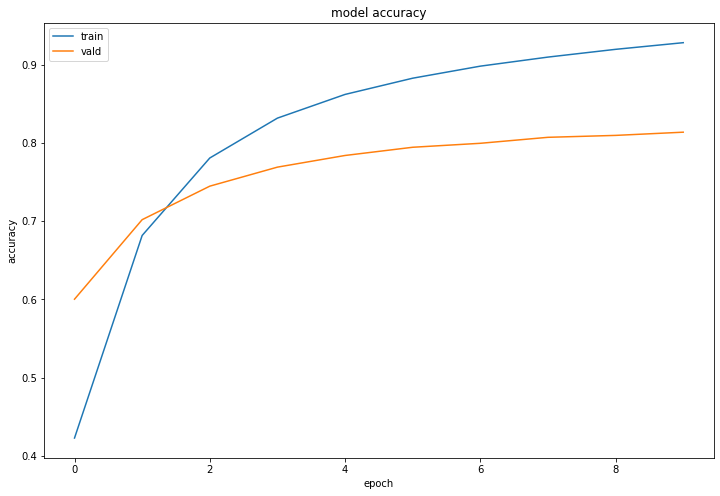

In [18]:
import matplotlib.pyplot as plt

# Tracé de l'exactitude en fonction des epochs

plt.figure(figsize=(12,8))
plt.plot(history_seq2seq.history['accuracy'])
plt.plot(history_seq2seq.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vald'], loc='upper left')
plt.show()

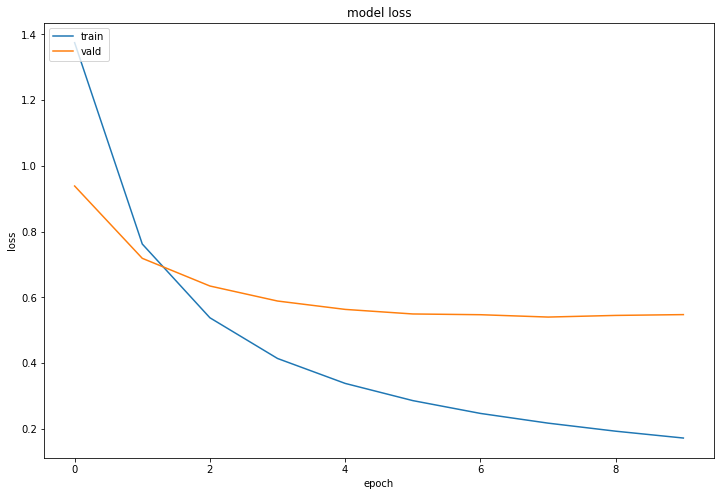

In [19]:
# Tracé des loss en fonction des epochs

plt.figure(figsize = (12,8))
plt.plot(history_seq2seq.history['loss'])
plt.plot(history_seq2seq.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vald'], loc='upper left')
plt.show()

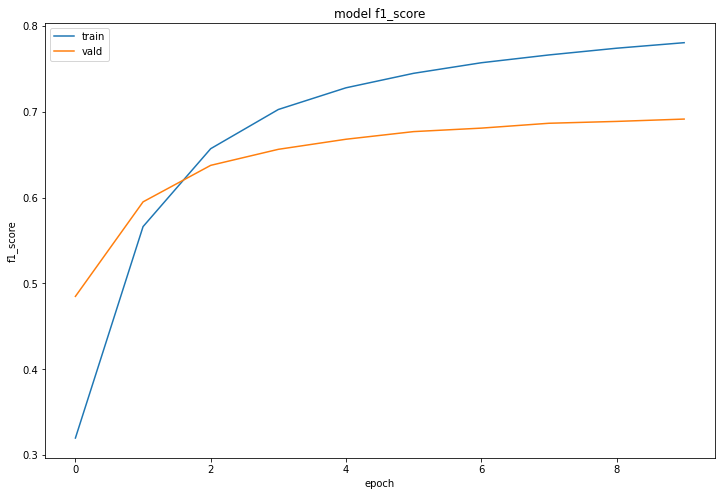

In [20]:
# Tracé du f1-score en fonction des epochs

plt.figure(figsize = (12,8))
plt.plot(history_seq2seq.history['f1_score'])
plt.plot(history_seq2seq.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'vald'], loc='upper left')
plt.show()

In [21]:
# Nouvelle utilisation de l'encodeur pour le modèle d'inférence 
encoder_model = Model(encoder_input, encoder_states)

# Architecture du second décodeur
decoder_state_input_h = Input(shape=(250,))
decoder_state_input_c= Input(shape=(250,))
decoder_states_input= [decoder_state_input_h, decoder_state_input_c]
dec_embd2 = decoder_embd(decoder_input)
decoder_output2,state_h2, state_c2 = decoder_lstm(dec_embd2, initial_state=decoder_states_input)
deccoder_states2= [state_h2, state_c2]

# Prédiction 
decoder_output2 = decoder_dense(decoder_output2)


decoder_model = Model(
                      [decoder_input]+decoder_states_input,
                      [decoder_output2]+ deccoder_states2)

In [22]:
def get_predicted_label(input_seq):

    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = dict_char_index['<s>']
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = dict_index_char[sampled_token_index]
        
        if (sampled_char == '<\s>' or len(decoded_sentence) > 3):
            stop_condition = True
        else : 
            decoded_sentence += sampled_char

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        states_value = [h, c]
           
    return decoded_sentence

In [23]:
df_test = pd.read_csv("test.csv")

In [32]:
input_texts_test = []
target_labels_test = []

base_labels_test = df_test.ICD10.values
base_texts_test = df_test.RawText.values

for idx_sample in range(len(df_test.ICD10)) : 

    base_text_test = base_texts_test[idx_sample]
    base_label_test = base_labels_test[idx_sample]
    
    input_text_test = base_text_test.split()
    target_label_test =  ["<s>"] + list(base_label_test) + ["</s>"]    

    input_texts_test.append(input_text_test)
    target_labels_test.append(target_label_test)

In [33]:
test_gen= data_batch_generator(input_texts_test,target_labels_test,batch_size=1)
 
Actual_test_sent = df_test.RawText.values
Actual_test_trans= df_test.ICD10.values

test_inputs=[]
test_outputs=[]

In [34]:
for (input, output),_ in tqdm(iter(test_gen)):
    test_inputs.append(input)
    test_outputs.append(output)

86172it [07:14, 198.17it/s]


KeyboardInterrupt: 

In [28]:
nb_test = 10
for idx_pred in range(nb_test) :
    print("Text:", Actual_test_sent[idx_pred])
    print("True Label:", Actual_test_trans[idx_pred])
    print("Predicted Label:", get_predicted_label(test_inputs[idx_pred]))
    print("\n")

Text: Douleur
True Label: R529
Predicted Label: R52</s>


Text: Rupture artère splénique
True Label: S352
Predicted Label: S352


Text: PNO
True Label: S270
Predicted Label: J939


Text: BK pulmonaire ancien
True Label: B909
Predicted Label: B90I


Text: Infection intestin Giardia
True Label: A071
Predicted Label: A0I1


Text: Hypoglycémie néonatale
True Label: P704
Predicted Label: P761


Text: Lésion voir aussi Maladiemastoïdienne, due à traumatisme obstétrical
True Label: P152
Predicted Label: P143


Text: Thrombose vasculaire veineuse
True Label: O873
Predicted Label: I829


Text: Bradycardie sinusale
True Label: I495
Predicted Label: I498


Text: Cancer joue gauche
True Label: C760
Predicted Label: C760


